# Credit Default Modeling at Taiwan International Bank

This Python script addresses a credit default prediction problem based on the case study "Credit Default Modeling at Taiwan International Bank" by Anton S. Ovchinnikov and Spyros Zoumpoulis, Insead. The objective is to build a data-driven model to predict which credit card customers are likely to default. 

Key goals of the project:
1. Apply supervised machine learning methods to make informed business decisions.
2. Use classification modeling to predict credit defaults.
3. Implement and compare multiple machine learning algorithms.
4. Train, validate, and test the model for accuracy.
5. Apply feature engineering techniques to improve prediction performance.

This project aims to develop a predictive model to assist the bank in managing credit risk effectively.

Link of the case study: https://publishing.insead.edu/case/taiwan-international-bank


# Importing Data and Libraries

In [2]:
import pycaret
from pycaret.classification import *
import pandas as pd
import numpy as np
from pycaret.classification import *

data_train=pd.read_csv(r'E:\Queens Academic\Done Subjects\Predictive Modeling\Team Assignment\6722-credit-card-default-data.csv')
data_test=pd.read_csv(r'E:\Queens Academic\Done Subjects\Predictive Modeling\Team Assignment\6722-pilot-customers.csv')

In [3]:
data_train.shape, data_test.shape

((24000, 25), (1000, 24))

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         24000 non-null  int64  
 1   LIMIT_BAL  24000 non-null  float64
 2   SEX        24000 non-null  int64  
 3   EDUCATION  24000 non-null  int64  
 4   MARRIAGE   24000 non-null  int64  
 5   AGE        24000 non-null  int64  
 6   PAY_1      24000 non-null  int64  
 7   PAY_2      24000 non-null  int64  
 8   PAY_3      24000 non-null  int64  
 9   PAY_4      24000 non-null  int64  
 10  PAY_5      24000 non-null  int64  
 11  PAY_6      24000 non-null  int64  
 12  BILL_AMT1  24000 non-null  float64
 13  BILL_AMT2  24000 non-null  float64
 14  BILL_AMT3  24000 non-null  float64
 15  BILL_AMT4  24000 non-null  float64
 16  BILL_AMT5  24000 non-null  float64
 17  BILL_AMT6  24000 non-null  float64
 18  PAY_AMT1   24000 non-null  float64
 19  PAY_AMT2   24000 non-null  float64
 20  PAY_AM

In [5]:
#Check for duplicate values
print(data_train.duplicated().sum()), print(data_test.duplicated().sum())

0
0


(None, None)

# Basic Model Building

Comparing multiple models via pycaret to get a rough estimate of which model is working better on this data set 

In [6]:
s = setup(data = data_train, target = 'DEFAULT', session_id = 123, ignore_features=['ID'])
best = compare_models()

,Description,Value
0,Session id,123
1,Target,DEFAULT
2,Target type,Binary
3,Original data shape,"(24000, 25)"
4,Transformed data shape,"(24000, 24)"
5,Transformed train set shape,"(16800, 24)"
6,Transformed test set shape,"(7200, 24)"
7,Ignore features,1
8,Numeric features,23
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8214,0.7840,0.3751,0.6726,0.4812,0.3838,0.4079,2.3920
lightgbm,Light Gradient Boosting Machine,0.8203,0.7768,0.3756,0.6664,0.4802,0.3816,0.4047,0.2420
catboost,CatBoost Classifier,0.8189,0.7810,0.3810,0.6563,0.4817,0.3812,0.4022,8.0360
ada,Ada Boost Classifier,0.8186,0.7748,0.3325,0.6850,0.4473,0.3541,0.3874,0.5120
lda,Linear Discriminant Analysis,0.8129,0.7226,0.2719,0.6985,0.3910,0.3049,0.3527,0.0350
rf,Random Forest Classifier,0.8124,0.7645,0.3670,0.6313,0.4637,0.3596,0.3793,1.6190
xgboost,Extreme Gradient Boosting,0.8117,0.7575,0.3724,0.6242,0.4663,0.3608,0.3786,0.3770
et,Extra Trees Classifier,0.8089,0.7516,0.3667,0.6142,0.4590,0.3518,0.3692,0.6720
ridge,Ridge Classifier,0.8014,0.0000,0.1621,0.7296,0.2650,0.2008,0.2782,0.0220
lr,Logistic Regression,0.7789,0.6468,0.0003,0.1000,0.0005,0.0003,0.0033,1.1470


To make business sense out of it, defining the profit mechanism of each correctly predicted non-default and correctly predicted default, assumption of LTV and default loss are also incorporated accordingly so that instead of just looking at accuracy we can see what business value each model can bring in the end

In [7]:
def profit_metric(y_true, y_pred):
    profit = 0
    for true, pred in zip(y_true, y_pred):
        if true == 0 and pred == 0:  # No default and predicted no default
            profit += 1500
        elif true == 1 and pred == 0:  # Default and predicted no default
            profit -= 5000
    return profit
add_metric(id='profit_metric', name='Profit', score_func=profit_metric)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                      make_scorer(profit_metric)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit_metric, dtype: object

In [8]:
best_threshold = compare_models(sort='profit_metric')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
catboost,CatBoost Classifier,0.8189,0.7810,0.3810,0.6563,0.4817,0.3812,0.4022,701800.0000,8.1390
gbc,Gradient Boosting Classifier,0.8214,0.7840,0.3751,0.6726,0.4812,0.3838,0.4079,700550.0000,2.8430
lightgbm,Light Gradient Boosting Machine,0.8203,0.7768,0.3756,0.6664,0.4802,0.3816,0.4047,698400.0000,0.3800
xgboost,Extreme Gradient Boosting,0.8117,0.7575,0.3724,0.6242,0.4663,0.3608,0.3786,672600.0000,0.3270
rf,Random Forest Classifier,0.8124,0.7645,0.3670,0.6313,0.4637,0.3596,0.3793,667400.0000,1.4280
et,Extra Trees Classifier,0.8089,0.7516,0.3667,0.6142,0.4590,0.3518,0.3692,658050.0000,0.8750
ada,Ada Boost Classifier,0.8186,0.7748,0.3325,0.6850,0.4473,0.3541,0.3874,638050.0000,0.5700
lda,Linear Discriminant Analysis,0.8129,0.7226,0.2719,0.6985,0.3910,0.3049,0.3527,545050.0000,0.0490
dt,Decision Tree Classifier,0.7233,0.6110,0.4085,0.3827,0.3949,0.2160,0.2163,496750.0000,0.0960
qda,Quadratic Discriminant Analysis,0.4843,0.7232,0.8385,0.2790,0.4185,0.1297,0.1958,453300.0000,0.0240


Defining the probability threshold for default, as by standard, it is at 50%, but we can change it to adjust in a way that maximizes our profit, as the business goal is to maximize profit.

In [9]:
def find_best_threshold(model, data, target, start=0.1, end=0.4, step=0.01):
    best_threshold = None
    best_profit = float('-inf')

    for threshold in np.arange(start, end + step, step):
        predictions = predict_model(model, data=data, raw_score=True)
        y_true = data[target]
        y_proba = predictions['prediction_score_1']  # is the probability that it belongs to class '1'

        # Apply threshold
        y_pred = (y_proba >= threshold).astype(int)

        # Calculate profit
        profit = profit_metric(y_true, y_pred)

        # Update best threshold if profit is higher
        if profit > best_profit:
            best_profit = profit
            best_threshold = threshold

    return best_threshold, best_profit

# Train the model
model = best_threshold

# Find the best threshold from 0.10 to 0.40 as we tried different range.
best_threshold, best_profit = find_best_threshold(model, data_train, 'DEFAULT', start=0.1, end=0.4, step=0.01)
best_threshold, best_profit

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,CatBoost Classifier,0.8477,0.8617,0.4425,0.7711,0.5623,0.4782,0.5052,12205500


(0.20999999999999996, 16234500)

The best threshold to maximize profit is 20.99%. Therefore, we would rebuild the model with this probability score.

In [10]:
best_threshold = compare_models(sort='profit_metric',probability_threshold=0.20999999999999996)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
gbc,Gradient Boosting Classifier,0.7589,0.7840,0.6494,0.4677,0.5437,0.3857,0.3954,899550.0000,2.7050
catboost,CatBoost Classifier,0.7538,0.7810,0.6505,0.4600,0.5387,0.3775,0.3882,888050.0000,6.8500
lightgbm,Light Gradient Boosting Machine,0.7460,0.7768,0.6575,0.4494,0.5337,0.3676,0.3803,877500.0000,0.2260
xgboost,Extreme Gradient Boosting,0.7341,0.7575,0.6287,0.4308,0.5111,0.3372,0.3487,810200.0000,0.2550
rf,Random Forest Classifier,0.6929,0.7645,0.6888,0.3901,0.4980,0.3005,0.3258,784450.0000,1.5240
et,Extra Trees Classifier,0.6983,0.7516,0.6694,0.3932,0.4952,0.3003,0.3221,772750.0000,0.5720
lda,Linear Discriminant Analysis,0.7014,0.7226,0.6338,0.3918,0.4841,0.2902,0.3068,734350.0000,0.0330
dt,Decision Tree Classifier,0.7232,0.6110,0.4101,0.3828,0.3958,0.2166,0.2169,498400.0000,0.0970
lr,Logistic Regression,0.5026,0.6468,0.7561,0.2738,0.4019,0.1145,0.1590,392400.0000,0.9710
ridge,Ridge Classifier,0.8014,0.0000,0.1621,0.7296,0.2650,0.2008,0.2782,373300.0000,0.0170


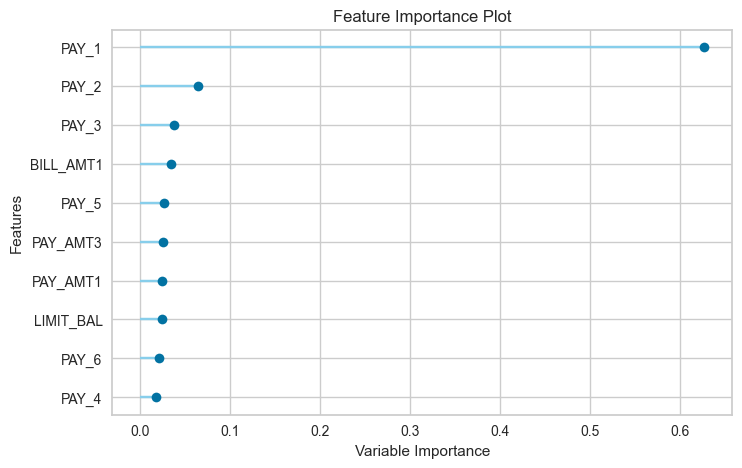

In [11]:
plot_model(best_threshold,plot='feature')

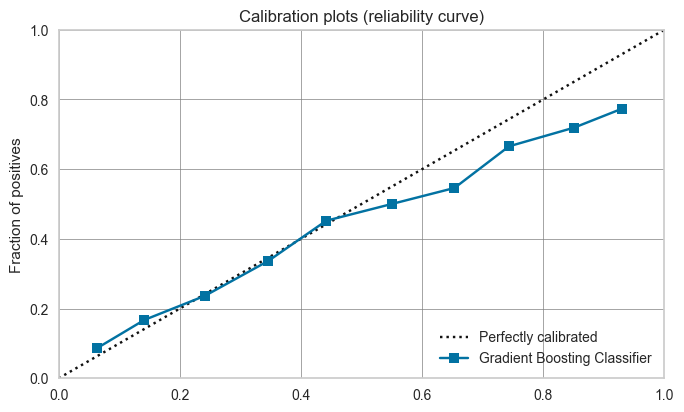

In [12]:
plot_model(best_threshold,plot='calibration')

Confusion Matrix to see True Positive, True Negative, False Positive and False Negative

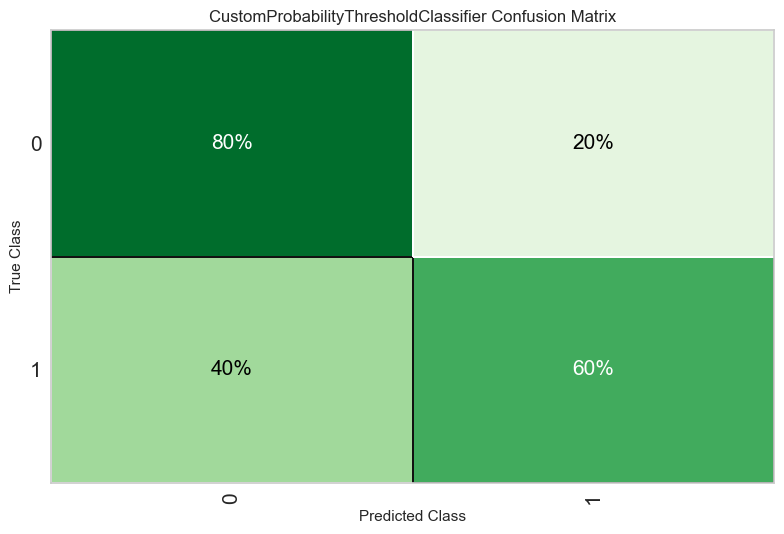

In [13]:
plot_model(best_threshold, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

In [14]:
best_threshold

CustomProbabilityThresholdClassifier(ccp_alpha=0.0,
                                     classifier=GradientBoostingClassifier(ccp_alpha=0.0,
                                                                           criterion='friedman_mse',
                                                                           init=None,
                                                                           learning_rate=0.1,
                                                                           loss='log_loss',
                                                                           max_depth=3,
                                                                           max_features=None,
                                                                           max_leaf_nodes=None,
                                                                           min_impurity_decrease=0.0,
                                                                           min_samples_leaf=1,
                                                                           min_samples_split=2,
                                                                           min_weight_fraction_leaf=0.0,
                                                                           n_estimators=100,
                                                                           n_iter_no_change=...
                                     learning_rate=0.1, loss='log_loss',
                                     max_depth=3, max_features=None,
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_iter_no_change=None,
                                     probability_threshold=0.20999999999999996,
                                     random_state=123, subsample=1.0,
                                     tol=0.0001, validation_fraction=0.1,
                                     verbose=0, warm_start=False)

# Model Building with Feature Engieering

In [15]:
# Create new features 'utilization_rate_i' and 'payment_ratio_i'

for i in range(1, 7):
     data_train[f'utilization_rate_{i}'] = data_train[f'BILL_AMT{i}'] / data_train['LIMIT_BAL']
     data_train[f'payment_ratio_{i}'] = data_train[f'PAY_AMT{i}'] / data_train[f'BILL_AMT{i}']

     data_train[f'payment_ratio_{i}'].replace([float('inf'), -float('inf')], 0, inplace=True)
     data_train[f'payment_ratio_{i}'].fillna(0, inplace=True)


data_train['avg_payment_delay'] = data_train[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].mean(axis=1)

In [16]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  24000 non-null  int64  
 1   LIMIT_BAL           24000 non-null  float64
 2   SEX                 24000 non-null  int64  
 3   EDUCATION           24000 non-null  int64  
 4   MARRIAGE            24000 non-null  int64  
 5   AGE                 24000 non-null  int64  
 6   PAY_1               24000 non-null  int64  
 7   PAY_2               24000 non-null  int64  
 8   PAY_3               24000 non-null  int64  
 9   PAY_4               24000 non-null  int64  
 10  PAY_5               24000 non-null  int64  
 11  PAY_6               24000 non-null  int64  
 12  BILL_AMT1           24000 non-null  float64
 13  BILL_AMT2           24000 non-null  float64
 14  BILL_AMT3           24000 non-null  float64
 15  BILL_AMT4           24000 non-null  float64
 16  BILL

In [17]:
s = setup(data = data_train, target = 'DEFAULT', session_id = 123, ignore_features=['ID'])

,Description,Value
0,Session id,123
1,Target,DEFAULT
2,Target type,Binary
3,Original data shape,"(24000, 38)"
4,Transformed data shape,"(24000, 37)"
5,Transformed train set shape,"(16800, 37)"
6,Transformed test set shape,"(7200, 37)"
7,Ignore features,1
8,Numeric features,36
9,Preprocess,True


In [18]:
def profit_metric(y_true, y_pred):
    profit = 0
    for true, pred in zip(y_true, y_pred):
        if true == 0 and pred == 0:  # No default and predicted no default
            profit += 1500
        elif true == 1 and pred == 0:  # Default and predicted no default
            profit -= 5000
    return profit

In [19]:
add_metric(id='profit_metric', name='Profit', score_func=profit_metric)

Name                                                            Profit
Display Name                                                    Profit
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                      make_scorer(profit_metric)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: profit_metric, dtype: object

In [20]:
best_threshold = compare_models(sort='profit_metric')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
gbc,Gradient Boosting Classifier,0.8219,0.7868,0.3823,0.6709,0.4866,0.3886,0.4113,711200.0000,5.0280
catboost,CatBoost Classifier,0.8192,0.7844,0.3778,0.6595,0.4799,0.3802,0.4020,698350.0000,8.7380
lightgbm,Light Gradient Boosting Machine,0.8201,0.7811,0.3756,0.6646,0.4796,0.3809,0.4038,697800.0000,0.3250
rf,Random Forest Classifier,0.8133,0.7644,0.3721,0.6333,0.4683,0.3643,0.3835,676300.0000,2.7130
xgboost,Extreme Gradient Boosting,0.8102,0.7612,0.3726,0.6175,0.4645,0.3577,0.3747,669200.0000,0.3910
et,Extra Trees Classifier,0.8100,0.7555,0.3721,0.6176,0.4638,0.3570,0.3742,667900.0000,0.9020
ada,Ada Boost Classifier,0.8186,0.7788,0.3473,0.6755,0.4585,0.3627,0.3919,657450.0000,0.9950
lda,Linear Discriminant Analysis,0.8136,0.7223,0.2814,0.6951,0.3999,0.3123,0.3575,558950.0000,0.0690
dt,Decision Tree Classifier,0.7241,0.6094,0.4031,0.3826,0.3923,0.2141,0.2144,491700.0000,0.2070
ridge,Ridge Classifier,0.8030,0.0000,0.1729,0.7321,0.2793,0.2128,0.2885,391350.0000,0.0300


In [21]:
def find_best_threshold(model, data, target, start=0.1, end=0.4, step=0.01):
    best_threshold = None
    best_profit = float('-inf')

    for threshold in np.arange(start, end + step, step):
        predictions = predict_model(model, data=data, raw_score=True)
        y_true = data[target]
        y_proba = predictions['prediction_score_1']  # is the probability that it belongs to class '1'

        # Apply threshold
        y_pred = (y_proba >= threshold).astype(int)

        # Calculate profit
        profit = profit_metric(y_true, y_pred)

        # Update best threshold if profit is higher
        if profit > best_profit:
            best_profit = profit
            best_threshold = threshold

    return best_threshold, best_profit

# Train the model
model = best_threshold

# Find the best threshold from 0.10 to 0.40 as we tried different range.
best_threshold, best_profit = find_best_threshold(model, data_train, 'DEFAULT', start=0.1, end=0.4, step=0.01)
best_threshold, best_profit

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit
0,Gradient Boosting Classifier,0.8266,0.8061,0.3845,0.6951,0.4951,0.4007,0.4263,10368500


(0.21999999999999995, 13525500)

In [22]:
best_threshold = compare_models(sort='profit_metric',probability_threshold=0.21999999999999995)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Profit,TT (Sec)
gbc,Gradient Boosting Classifier,0.7585,0.7868,0.6416,0.4667,0.5402,0.3820,0.3910,888500.0000,5.3000
catboost,CatBoost Classifier,0.7579,0.7844,0.6400,0.4656,0.5389,0.3803,0.3893,884750.0000,9.1090
lightgbm,Light Gradient Boosting Machine,0.7488,0.7811,0.6414,0.4525,0.5304,0.3660,0.3765,863700.0000,0.2920
xgboost,Extreme Gradient Boosting,0.7461,0.7612,0.6187,0.4465,0.5186,0.3523,0.3610,827550.0000,0.3180
et,Extra Trees Classifier,0.7068,0.7555,0.6707,0.4023,0.5028,0.3129,0.3336,795950.0000,0.9080
rf,Random Forest Classifier,0.6964,0.7644,0.6871,0.3934,0.5002,0.3047,0.3292,791050.0000,2.7000
lda,Linear Discriminant Analysis,0.7276,0.7223,0.6047,0.4196,0.4954,0.3171,0.3271,762700.0000,0.0750
dt,Decision Tree Classifier,0.7239,0.6094,0.4041,0.3825,0.3928,0.2144,0.2146,492500.0000,0.2250
lr,Logistic Regression,0.5239,0.6478,0.7291,0.2791,0.4037,0.1234,0.1636,410950.0000,0.4540
ridge,Ridge Classifier,0.8030,0.0000,0.1729,0.7321,0.2793,0.2128,0.2885,391350.0000,0.0330


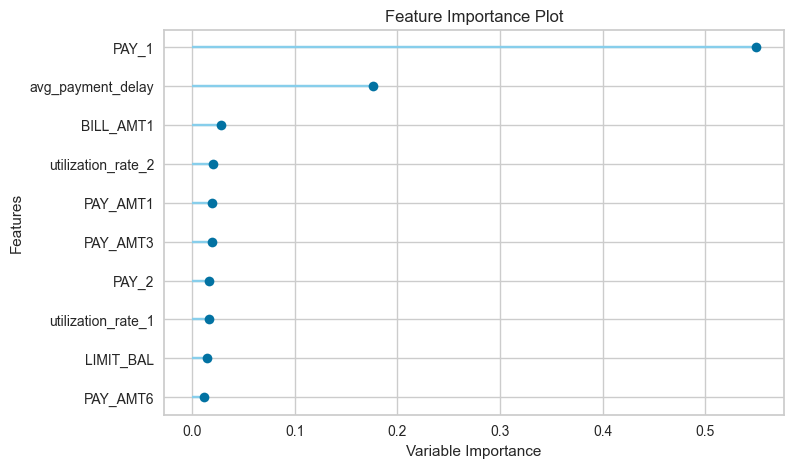

In [23]:
plot_model(best_threshold,plot='feature')

We can see that a few of the newly featured variables are also coming up as important variables, but PAY_1 is still the most important variable, which influences a person’s default probability

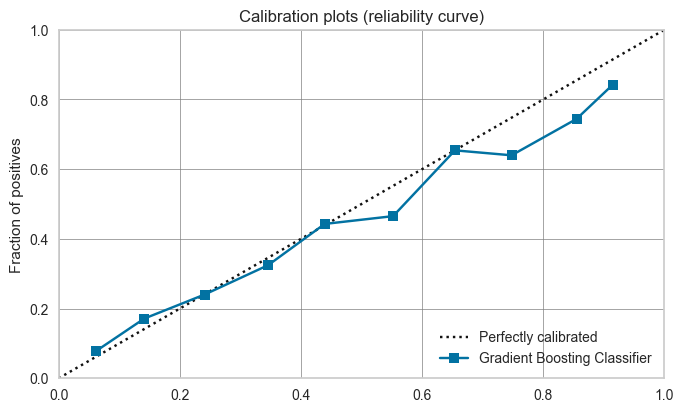

In [24]:
plot_model(best_threshold,plot='calibration')

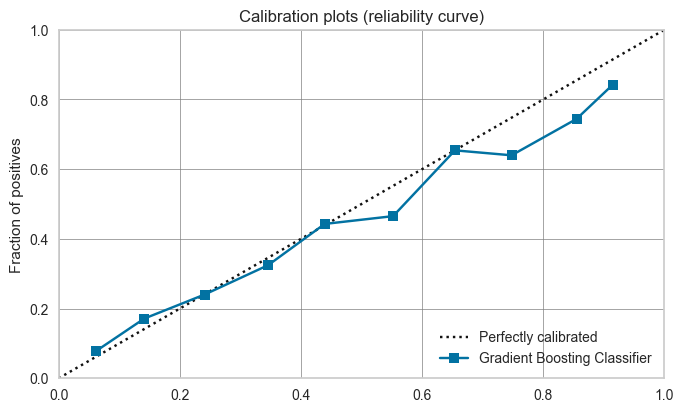

In [25]:
plot_model(best_threshold,plot='calibration')

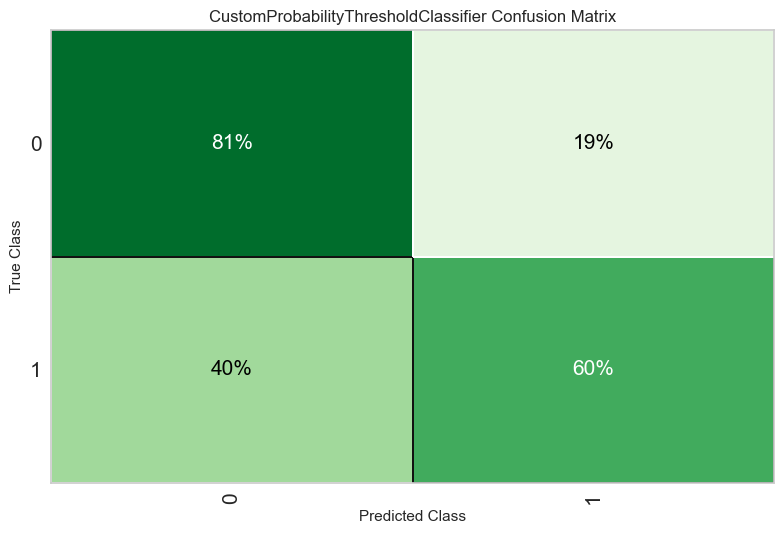

In [27]:
plot_model(best_threshold, plot = 'confusion_matrix', plot_kwargs = {'percent' : True})

Conclusion

In this project, several machine learning models were implemented to predict credit defaults at Taiwan International Bank. Various techniques, including feature engineering, were applied to enhance model performance. After comparing multiple models, the Gradient Boosting Classifier achieved the highest accuracy and AUC, making it the most effective model for predicting defaults.

Interestingly, the model without feature engineering resulted in the highest profit for the bank, indicating that simpler models may sometimes outperform more complex ones in real-world financial applications.

Overall, this analysis highlights the importance of model selection and testing different approaches to optimize both performance and business outcomes
